# AstroDataton - Catatongelo!

### Imports básicos

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import glob

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, AveragePooling2D, Conv2DTranspose, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

### Funciónes útiles

In [4]:
def plot_epsilon(epsilon) -> None:
    e1 = epsilon[0, :]
    e2 = epsilon[1, :]
    delta_e = epsilon[2, :]
    # Crear una figura con tres subplots
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    vmin = min(e1.min(), e2.min(), delta_e.min())
    vmax = max(e1.max(), e2.max(), delta_e.max())

    # Mostrar cada imagen en su subplot correspondiente
    cmap = 'viridis'  # Colormap azul-blanco-rojo

    im1 = axs[0].imshow(e1, cmap=cmap, vmin=vmin, vmax=vmax)
    axs[0].set_title(r'$\epsilon_{1}$')

    im2 = axs[1].imshow(e2, cmap=cmap, vmin=vmin, vmax=vmax)
    axs[1].set_title(r'$\epsilon_{2}$')

    im3 = axs[2].imshow(delta_e, cmap=cmap, vmin=vmin, vmax=vmax)
    axs[2].set_title(r'$\Delta\epsilon$')

    # Añadir una barra de color
    cbar = fig.colorbar(im1, ax=axs, orientation='horizontal', fraction=0.02, pad=0.1)
    cbar.set_label(r'$\epsilon$')

    # Añadir un título global
    fig.suptitle('Imágenes de entrada para el problema', fontsize=16)

    # Mostrar la figura
    #plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def plot_kappa(kappa) -> None:
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    cmap = 'viridis'
    im = ax.imshow(kappa, cmap=cmap, vmin=kappa.min(), vmax=kappa.max())
    ax.set_title('Imágen de salida esperada para el problema')
    cbar = fig.colorbar(im, ax=ax, orientation='horizontal', fraction=0.02, pad=0.1)
    cbar.set_label(r'$\kappa$')
    #plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


## Problema y Datos
El problema a resolver consiste en lograr generar los mapas de convergencia $\kappa$ a partir de las elipticidades $\epsilon_{1}$, $\epsilon_{2}$ y $\Delta\epsilon$ distorsionadas por el fenómeno de weak lensing. 

En otras palabras tenemos un input de 3 imágenes de 128x128 y un output deseado de una imágen de 128x128.
A continuación les mostramos como descargar los datos y una breve visualización de un caso ejemplo.

Los datos consisten de 8 conjuntos de entrenamiento, cada uno con un peso de alrededor de 10GB descomprimidos, y un conjunto de validación también de alrededor de 10GB descomprimido. Dependerá de ustedes si quieren usar todos los conjuntos de entrenamiento o solo algunos, pero deben tener en cuenta que no hay datos repetidos entre conjuntos, estos son completamente independientes entre sí.

Para descargar los datos podemos usar el comando wget con el link de descarg correspondiente al conjunto deseado, en este ejemplo descargaremos el conjunto de entrenamiento 1:

Luego podemos visualizar las imágenes cargandolas con numpy, para esto obtendremos la dirección de solo la primera imágen del conjunto 1.

In [8]:
dataset_number = 2

EP_pth = glob.glob(f"{dataset_number}/EPSILON/*.npy")[0]
KA_pth = glob.glob(f"{dataset_number}/KAPPA/*.npy")[0]

EP_pth, KA_pth

('2/EPSILON\\00104_00001.npy', '2/KAPPA\\00104_00001.npy')

Luego cargaremos y visualizaremos las imágenes:

Shape de imágen epsilon: (3, 128, 128)
Shape de imágen kappa: (128, 128)


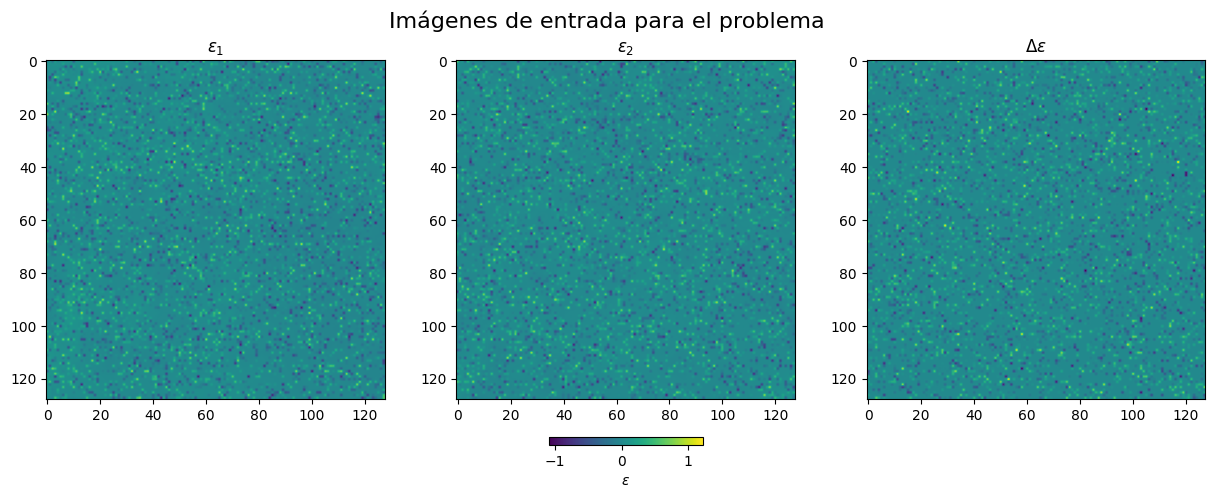

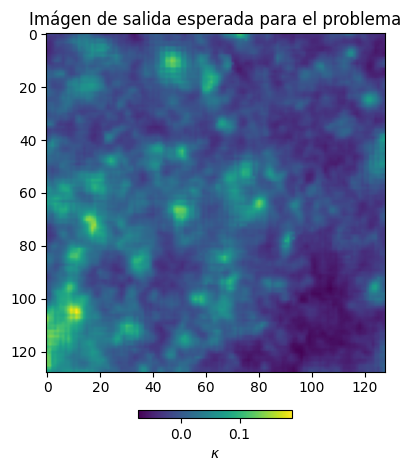

In [9]:
EP = np.load(EP_pth)
KA = np.load(KA_pth)

print(f"Shape de imágen epsilon: {EP.shape}")
print(f"Shape de imágen kappa: {KA.shape}")

plot_epsilon(EP)
plot_kappa(KA)

In [11]:
EP.shape

(3, 128, 128)

In [65]:
EP = EP.reshape((1,128,128,3))
KA = KA.reshape((1,128,128))
X_train = EP
Y_train = KA

In [66]:
input_layer = Input(shape=(128, 128, 3))

conv1 = Conv2D(8, (3, 3), padding='same', activation='tanh')(input_layer)

transconv1 = Conv2DTranspose(8, (49, 49), activation='tanh')(conv1)
conv2 = Conv2D(8, (49, 49), activation='tanh')(transconv1)
multiply1 = Multiply()([conv2, conv1])

transconv2 = Conv2DTranspose(8, (49, 49), activation='tanh')(multiply1)
conv3 = Conv2D(8, (49, 49),  activation='tanh')(transconv2)
multiply2 = Multiply()([conv3, multiply1])

transconv3 = Conv2DTranspose(8, (49, 49),  activation='tanh')(multiply2)
conv4 = Conv2D(8, (49, 49),  activation='tanh')(transconv3)
multiply3 = Multiply()([conv4, multiply2])

transconv4 = Conv2DTranspose(8, (49, 49),  activation='tanh')(multiply3)
conv5 = Conv2D(8, (49, 49), activation='tanh')(transconv4)
multiply4 = Multiply()([conv5, multiply1])

transconv5 = Conv2DTranspose(16, (49, 49), activation='tanh')(multiply4)
output_layer = Conv2D(1, (49, 49), activation='tanh')(transconv5)

model = Model(inputs=input_layer, outputs=output_layer)
model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_77 (Conv2D)  │ (None, 128, 128,  │        224 │ input_layer_15[0… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_53 │ (None, 176, 176,  │    153,672 │ conv2d_77[0][0]   │
│ (Conv2DTranspose)   │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_78 (Conv2D)  │ (None, 128, 128,  │    153,672 │ conv2d_transpose… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_43         │ (None, 128, 128,  │          0 │ conv2d_78[0][0],  │
│ (Multiply)          │ 8)                │            │ conv2d_77[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_54 │ (None, 176, 176,  │    153,672 │ multiply_43[0][0] │
│ (Conv2DTranspose)   │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_79 (Conv2D)  │ (None, 128, 128,  │    153,672 │ conv2d_transpose… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_44         │ (None, 128, 128,  │          0 │ conv2d_79[0][0],  │
│ (Multiply)          │ 8)                │            │ multiply_43[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_55 │ (None, 176, 176,  │    153,672 │ multiply_44[0][0] │
│ (Conv2DTranspose)   │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_80 (Conv2D)  │ (None, 128, 128,  │    153,672 │ conv2d_transpose… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_45         │ (None, 128, 128,  │          0 │ conv2d_80[0][0],  │
│ (Multiply)          │ 8)                │            │ multiply_44[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_56 │ (None, 176, 176,  │    153,672 │ multiply_45[0][0] │
│ (Conv2DTranspose)   │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_81 (Conv2D)  │ (None, 128, 128,  │    153,672 │ conv2d_transpose… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_46         │ (None, 128, 128,  │          0 │ conv2d_81[0][0],  │
│ (Multiply)          │ 8)                │            │ multiply_43[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_57 │ (None, 176, 176,  │    307,344 │ multiply_46[0][0] │
│ (Conv2DTranspose)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_82 (Conv2D)  │ (None, 128, 128,  │     38,417 │ conv2d_transpose… │
│                     │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,575,361 (6.01 MB)

 Trainable params: 1,575,361 (6.01 MB)

 Non-trainable params: 0 (0.00 B)

In [67]:


num_samples = 1

model.compile(optimizer=Adam(learning_rate=0.001),
              loss=BinaryCrossentropy())

history = model.fit(
    X_train, 
    Y_train, 
    epochs=100, 
    batch_size=16
)

Epoch 1/100


In [48]:
predicted_kappa.max()

1.3073038e-16

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


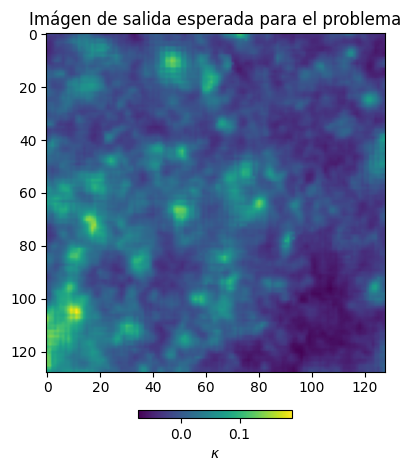

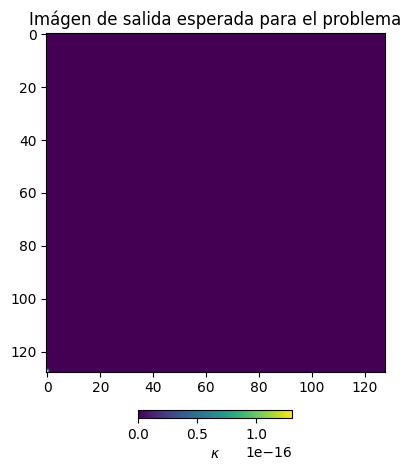

In [43]:
predicted_kappa = model.predict(EP)
plot_kappa(KA[0])
plot_kappa(predicted_kappa[0])